In [1]:
import csv
import pandas as pd
import re
import numpy as np
import sys, os
import scipy.stats 
from dateutil.parser import parse
from wikimedia import searchEntity, searchObjWProperty


In [2]:
allFile = os.listdir(os.getcwd()+"/data/dataKicut/")
allFile

['processed-data-titik-reklame-jakarta.csv',
 'data-rumah-sakit-kota-bandung.csv',
 'Data-Fasilitas-Dinas-Pemuda-dan-Olahraga.csv',
 'SMKRawanBanjir.csv',
 'processed-trayek-bus-jakarta.csv',
 'data-sekolah-di-kecamatan-cinambo.csv',
 'data-sekolah-kec.-sukajadi-2017.csv',
 'Data-Tempat-Pelelangan-Ikan-DKI-Jakarta-Tahun-2017.csv',
 'Data-Sarana-Fasilitas-Olahraga-Kota-Administrasi-Jakarta-Barat-edited.csv',
 'Data-Pelabuhan-K.Seribu-2017.csv',
 'Data-Sekolah-TK-PAUD-DKI-Jakarta-2018-edited.csv',
 'Data-Taman-Interaktif-di-Provinsi-DKI-Jakarta.csv',
 'data-tanah-kosong-sarana-olahraga-dan-taman-kec.rancasari-2014.csv',
 'daftar-taman-kota-bandung.csv',
 'Data-Jumlah-Fasilitas-Kesehatan-Tahun-2007---2014.csv',
 'Data-Pemakaman-di-Provinsi-DKI-Jakarta.csv',
 'data-sekolah-2018.csv',
 'Data-Pahlawan-Nasional-Beralamat-Di-Jabodetabek-Autosaved.csv',
 'data-taman-kec.arcamanik-2016.csv',
 'processed-hutan-kota-jakarta-luas-status-hukum-alamat.csv',
 'processed-data-taman-rekreasi-jakarta (1)

In [3]:
#GIBRAN THINGS
limit = 5
threshold = 0

def is_date(string):
    try: 
        parse(string)
        return True
    except ValueError:
        return False
    
def ranking(candidateList, goal, flag, propertyLbl):
    scoreList = [0] * len(candidateList)
    for i in range(len(candidateList)):
#         if(not flag):
#             results = searchObjWProperty(candidateList[i]['id'], 'P31')
#             if(len(results['results']['bindings']) > 0):
#                 temp = False
#                 for elem in results['results']['bindings']:
#                     if(elem['itemLabel']['value'].lower() == propertyLbl.lower()):
#                         temp = True
#                         break
#                 if(not temp):
#                     scoreList[i] = scoreList[i] - 5
        results = searchObjWProperty(candidateList[i]['id'], 'P17')
        if(len(results['results']['bindings']) > 0):
            if(results['results']['bindings'][0]['itemLabel']['value'] == 'Indonesia'):
                scoreList[i] = scoreList[i] + 1
        
        lblDis = lDistance(goal, candidateList[i]['label'].lower())
        aliDis = 10000000
        if('aliases' in candidateList[i]):
            aliDis = lDistance(goal, candidateList[i]['aliases'][0].lower())
        
        scoreList[i] = scoreList[i] - min(lblDis, aliDis)
    
    maxScore = max(scoreList)
    if(maxScore < threshold):
        return ''

    idx = scoreList.index(maxScore)
    return candidateList[idx]['id']

def searchID(flag, cell, rowHead):
    json = searchEntity(cell.lower(), limit)['search']
    id = ''
    if(len(json) > 1):
        id = ranking(json, cell.lower(), flag, rowHead)
    elif(len(json) == 1):
        id = json[0]['id']
    
    if(id == '' and flag):
        id = 'QNew'
    elif(id == ''):
        id = 'QNPNew'
        
    return id

def makeDatatypeMap(header_list, df):
    dtMap = []
    index = 0
    for elem in df.loc[0, header_list]:
        try:
            if(elem.replace('.','').replace(',', '').replace('-', '').replace(' ', '').isdigit()):
                index=index
            elif('jl.' in elem.lower()):
                index=index
            elif(is_date(elem)):
                index=index
            else:
#                 print(elem)
                dtMap.append(header_list[index])
        except AttributeError:
            index=index
        index=index+1
    return dtMap

def lDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

#jalan
def check_protagonist(df):
    ranking = {}
    for col in df.columns:
        entities = set()
        for index, row in df.iterrows():
            entities.add(row[col])
        ranking[col] = len(entities)
    return ranking

def give_verdict_base(df_entity, ranking_diversity):
    ranking = {}
    maxValue = -1
    maxColumn = ""
    for key, value in ranking_diversity.items():
        score = value + len(df_entity.columns)-list(df_entity.columns).index(key)
        if maxValue <= score:
            maxValue = score
            maxColumn = key
        ranking[key] = score
    return maxColumn, maxValue, ranking

def give_verdict_normalized(df_entity, ranking_diversity, weightDiverse=0.5, weightColumnOrder=0.5):
    df_length = df_entity.shape[0]
    ranking = {}
    maxValue = -1
    maxColumn = ""
    for key, value in ranking_diversity.items():
        diverseScore = value/df_length
        columnOrderScore = 1 - (list(df_entity.columns).index(key)/len(df_entity.columns))
        score = (weightDiverse * diverseScore) + (weightColumnOrder * columnOrderScore)
        if maxValue <= score:
            maxValue = score
            maxColumn = key
        ranking[key] = score
    return maxColumn, maxValue, ranking

#tie breaker on highest value . but the highest value has multiplice instances
def give_verdict_columntb(df_entity, ranking_diversity):
    df_length = df_entity.shape[0]
    ranking = {}
    maxValue = -1 #value can not be lower or equal to zero , so this is safe initial poin
    maxColumns = []
    for key, value in ranking_diversity.items():
        if value > maxValue:
            maxColumns=[key]
            maxValue = value
        elif value == maxValue:
            maxColumns.append(key)
        else:
            pass
        ranking[key] = value

    if len(maxColumns) > 1:
        maxOrderScore = -1  #value can not be lower or equal to zero , so this is safe initial poin
        for col in maxColumns:
            columnOrderScore = 1 - (list(df_entity.columns).index(key)/len(df_entity.columns))
            if columnOrderScore > maxOrderScore:
                maxColumns[0] = col
                maxOrderScore = columnOrderScore
            ranking[col] = ranking[col]+columnOrderScore
    return maxColumns[0], maxValue, ranking

#tie breaker on , if any, highest value that have multiplie instances ( So it could be , not the highest value , but highest value that has multiple instances)

#tie breaker on any multiple instances


#entropy
def give_verdict_entropy(df_entity):
    maxEntropy = -1
    maxColumn=""
    ranking={}
    for col in df_entity.columns:
        dummy, counts = np.unique(df_entity[col].astype(str), return_counts=True)
        probs = []
        numbers_of_data=df_entity.shape[0]
        for occ in counts:
            probs.append(occ/numbers_of_data)
        entropy = scipy.stats.entropy(probs)#base = e
#         print(str(type(entropy))+ " " + str(maxEntropy))
        if entropy > maxEntropy:
            maxEntropy=entropy
            maxColumn=col
        ranking[col]=entropy
    return maxColumn, maxEntropy, ranking



In [4]:
# file_names=[ 
#       'processed-data-titik-reklame-jakarta.csv',
#  'Data-Fasilitas-Dinas-Pemuda-dan-Olahraga.csv',
#  'SMKRawanBanjir.csv',
#  'Data-Tempat-Pelelangan-Ikan-DKI-Jakarta-Tahun-2017.csv',
#  'Data-Sarana-Fasilitas-Olahraga-Kota-Administrasi-Jakarta-Barat-edited.csv',
#  'Data-Jumlah-Fasilitas-Kesehatan-Tahun-2007---2014.csv',
#  'processed-data-taman-rekreasi-jakarta.csv',
#  'data-sekolah-tahun-2018.csv',
#  'data-sekolah-antapani-tahun-2018.csv',
#  'Data-Jumlah-Fasilitas-Pengumpul-Sampah-Sementara-Tahun-2007-2011.csv',
#  'Data-Sarana-Fasilitas-Olahraga-Kota-Administrasi-Jakarta-Barat-edited.csv.1',
#  'Tabel-Danau-Waduk-dan-Situ-DKI-Jakarta-Tahun-2014.csv',
#  'data-sarana-yankes-DKI-Jakarta-Tahun-2016-2017.csv',
#  'ruang-laktasi.csv',
#  'Data-Jumlah-Fasilitas-Kesehatan-KB-Di-DKI-Jakarta-Bulan-Januari-s-d-September-Tahun-2015.csv',
# ]
file_names = os.listdir(os.getcwd()+"/data/dataKicut/")

In [7]:
## Jalan MAIN 
hasil_sukses={}
hasil_gagal={}
for name in file_names:
    nama_file="data/dataKicut/"+name
    try:
        df = pd.read_csv(nama_file, encoding='latin-1')
        header_list = list(df)
        if 'No.' in header_list:
            header_list.remove('No.')
        header_list
        dtMap = makeDatatypeMap(header_list, df)
        hasil_verdict = determine_protagonist(df, dtMap)
        hasil_sukses[nama_file]=hasil_verdict
    except Exception as e:
        print("ERROR")
        print(e)
        hasil_gagal[nama_file]=e

hasil_sukses_df=pd.DataFrame.from_dict(hasil_sukses).transpose()

ERROR
list index out of range
ERROR
Error tokenizing data. C error: Expected 5 fields in line 3, saw 6

ERROR
Error tokenizing data. C error: Expected 1 fields in line 17, saw 2

ERROR
list index out of range
ERROR
list index out of range
ERROR
Error tokenizing data. C error: Expected 1 fields in line 18, saw 2



In [11]:
hasil_gagal
hasil_sukses_df.to_csv('newlabel.csv')

In [6]:
# Jalan MAIN
def determine_protagonist(df, dtMap):
    entity_columns = dtMap
    df_entity = df[entity_columns]
    ranking = check_protagonist(df_entity)
    hasil={}
    hasil['base'], score, info = give_verdict_base(df_entity, ranking)
    hasil['normalize-0.5:0.5'], score, info = give_verdict_normalized(df_entity, ranking)
    hasil['normalize-0.7:0.3'], score, info = give_verdict_normalized(df_entity, ranking, 0.7, 0.3)
    hasil['normalize-0.3:0.7'], score, info = give_verdict_normalized(df_entity, ranking, 0.3, 0.7)
    hasil['base-columntb'], score, info = give_verdict_columntb(df_entity, ranking)
    hasil['entropy'], score, info = give_verdict_entropy(df_entity)



    return hasil
#     for keys, value in hasil.items():
#         print(str(keys) + " : " + str(value))


In [12]:
#lets Crunch those bois
nama_file_label = os.getcwd()+"/data/information/label.csv"
label = pd.read_csv(nama_file_label, encoding='latin-1')
label.columns=['nama_file', 'label']
hasil_sukses_df['nama_file'] = hasil_sukses_df.index
result_df = hasil_sukses_df.merge(label, how='left')
result_df

,base,base-columntb,entropy,normalize-0.3:0.7,normalize-0.5:0.5,normalize-0.7:0.3,nama_file,label
0,nama_titik,nama_titik,nama_titik,nama_titik,nama_titik,nama_titik,data/dataKicut/processed-data-titik-reklame-ja...,nama_titik
1,nama_rs,nama_rs,nama_rs,nama_rs,nama_rs,nama_rs,data/dataKicut/data-rumah-sakit-kota-bandung.csv,nama_rs
2,gelanggang,gelanggang,gelanggang,gelanggang,gelanggang,gelanggang,data/dataKicut/Data-Fasilitas-Dinas-Pemuda-dan...,gelanggang
3,Nama Sekolah,Nama Sekolah,Nama Sekolah,Nama Sekolah,Nama Sekolah,Nama Sekolah,data/dataKicut/SMKRawanBanjir.csv,Nama Sekolah
4,rute_berangkat,rute_berangkat,rute_berangkat,no_trayek,no_trayek,no_trayek,data/dataKicut/processed-trayek-bus-jakarta.csv,rute_trayek
5,NAMA SEKOLAH,NAMA SEKOLAH,NAMA SEKOLAH,KECAMATAN,NAMA SEKOLAH,NAMA SEKOLAH,data/dataKicut/data-sekolah-di-kecamatan-cinam...,NAMA SEKOLAH
6,Nama Sekolah,Nama Sekolah,Nama Sekolah,Kecamatan,Nama Sekolah,Nama Sekolah,data/dataKicut/data-sekolah-kec.-sukajadi-2017...,Nama Sekolah
7,nama,nama,nama,nama,nama,nama,data/dataKicut/Data-Tempat-Pelelangan-Ikan-DKI...,nama
8,nama_pelabuhan,nama_pelabuhan,nama_pelabuhan,nama_pelabuhan,nama_pelabuhan,nama_pelabuhan,data/dataKicut/Data-Pelabuhan-K.Seribu-2017.csv,nama_pelabuhan
9,nama,nama,nama,nama,nama,nama,data/dataKicut/Data-Sekolah-TK-PAUD-DKI-Jakart...,nama


In [13]:
column_verdicts = list(result_df.columns[:list(result_df.columns).index("nama_file")])
acc = {}
true_count =  {}
for col in column_verdicts:
    name = col + "-acc"
    equality = np.where(result_df[col]==result_df['label'], True, False)
    unique, counts = np.unique(equality, return_counts=True)
    if(len(unique) > 1):
        acc[col] = counts[1]/(counts[0]+counts[1])
        true_count[col] = counts[1]
    elif unique[0] == True:
        acc[col] = 1.0
        true_count[col] = result_df.shape[0]
    elif unique[0] == False:
        acc[col] = 0.0
        true_count[col] = result_df.shape[0]


acc

{'base': 0.9210526315789473,
 'base-columntb': 0.9210526315789473,
 'entropy': 0.9210526315789473,
 'normalize-0.3:0.7': 0.631578947368421,
 'normalize-0.5:0.5': 0.8947368421052632,
 'normalize-0.7:0.3': 0.9210526315789473}

In [20]:
result_df.shape[0]

38

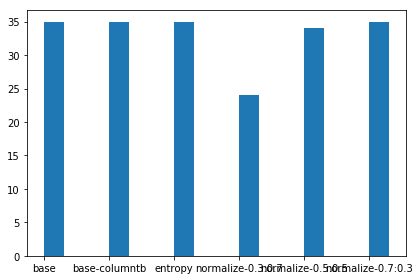

In [19]:
#lets draw those bois
import matplotlib.pyplot as plt

acc=true_count
plt.bar(range(len(acc)), list(acc.values()), align='edge', width=0.3)
plt.xticks(range(len(acc)), list(acc.keys()))
plt.tight_layout()
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()